In [1]:
import pickle
    
with open('cluster_abundance_fiducial_covariance.pkl', 'rb') as file:
    cluster_count_cov = pickle.load(file)

In [2]:
# import pickle
    
# with open('cluster_abundance_fiducial_covariance_shot_noise_only.pkl', 'rb') as file:
#     cluster_count_cov = pickle.load(file)

In [3]:
from emulator import *
from fisher_utils import *

In [4]:
z_bin_edges = [0.2, 0.4, 0.6, 0.8, 1.0]
richness_bin_edges = [20., 30., 45., 60., 300.]

n_z = len(z_bin_edges) - 1
n_r = len(richness_bin_edges) - 1
cov_matrix_2d = np.zeros((n_z * n_r, n_z * n_r))

for i in range(n_z):
    for j in range(n_z):
        for a in range(n_r):
            for b in range(n_r):
                row_index = i * n_r + a
                col_index = j * n_r + b
                cov_matrix_2d[row_index, col_index] = cluster_count_cov[i, j, a, b]


In [5]:
cov_inv = np.linalg.inv(cov_matrix_2d)

In [6]:
log10_rel_step_sizes = np.arange(-3.5,-0.5,0.1)
dμdθ_step_size = {}
for parameter_changed in tqdm(fiducial_cosmology.keys()):
    dμdθ_step_size[parameter_changed] = {}
    for log10_rel_step_size in log10_rel_step_sizes:
        cluster_abundance_pos = None
        cluster_abundance_neg = None
        with open('/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/cluster_abundance_fisher_%s_%.1f'%(parameter_changed, log10_rel_step_size), 'rb') as file:
            cluster_abundance_pos = pickle.load(file)

        with open('/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/cluster_abundance_fisher_%s_%.1f_neg'%(parameter_changed, log10_rel_step_size), 'rb') as file:
            cluster_abundance_neg = pickle.load(file)

        
        h = np.abs(fiducial_cosmology[parameter_changed]) * 10**log10_rel_step_size
        tmp_theory_deriv = (cluster_abundance_pos - cluster_abundance_neg) / (2 * h)
        flattened_theory_deriv = np.zeros((n_z * n_r))
        for i in range(n_z):
            for a in range(n_r):
                flattened_theory_deriv[i * n_r + a] = tmp_theory_deriv[i, a]
        dμdθ_step_size[parameter_changed][log10_rel_step_size] = flattened_theory_deriv


100%|██████████| 8/8 [00:00<00:00, 50.67it/s]


In [7]:
dμdθ_step_size.keys()

dict_keys(['10^9 As', 'ns', 'H0', 'w0', 'ombh2', 'omch2', 'nu_mass_ev', 'sigma8'])

In [8]:
labels = {
    '10^9 As': r'10^9A_s',
    'ns': r'n_s',
    'H0': r'H_0',
    'w0': r'w_0',
    'ombh2': r'\Omega_b h^2',
    'omch2': r'\Omega_c h^2',
    'nu_mass_ev': r'\sum m_\nu',
    'sigma8' : r'\sigma_8'
}

In [9]:
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 32
plt.rcParams['font.family'] = 'serif'


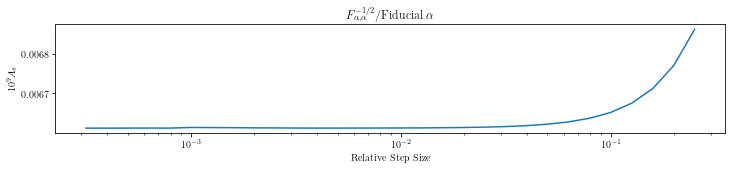

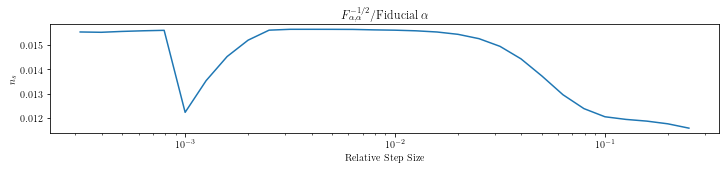

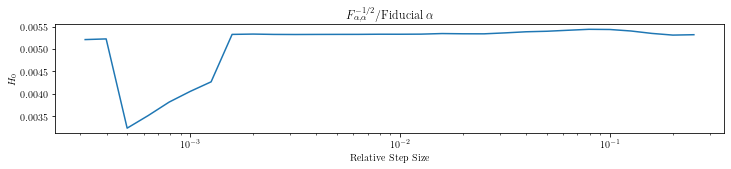

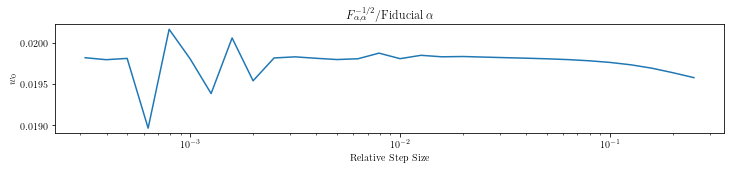

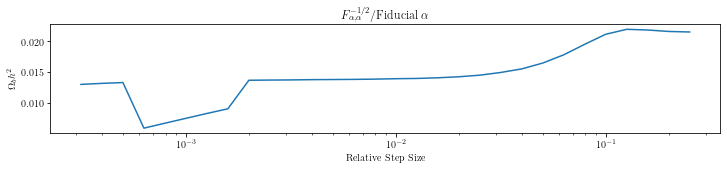

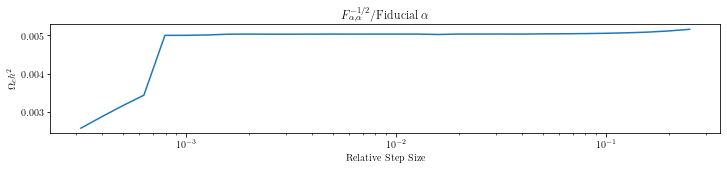

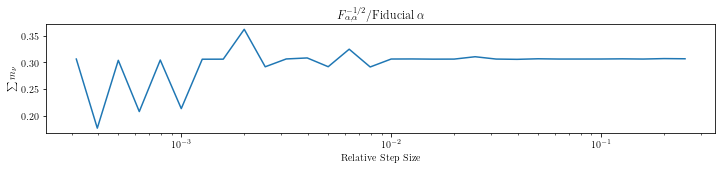

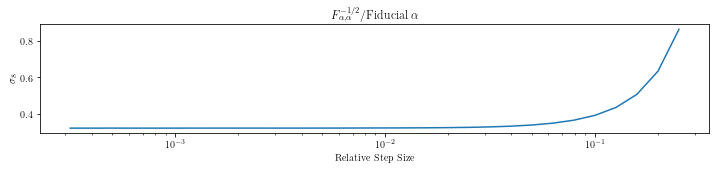

In [10]:
# First lets fix nu_mass_ev step size
for parameter_changed in (fiducial_cosmology.keys()):
    Fii = []
    Fii_inv = []
    plt.figure(figsize=(12,2))
    for log10_rel_step_size in log10_rel_step_sizes:
        curr_theory_deriv = dμdθ_step_size[parameter_changed][log10_rel_step_size]
        Fii_0 = np.einsum('l,lm,m', curr_theory_deriv, cov_inv, curr_theory_deriv)
        Fii += [Fii_0]
        Fii_inv += [Fii_0**(-1)]

    plt.plot(10**(log10_rel_step_sizes), np.abs(np.sqrt(Fii_inv)/fiducial_cosmology[parameter_changed]))
    plt.xscale('log')
    plt.xlabel('Relative Step Size')
    l = labels[parameter_changed]
    plt.title(r'$F_{\alpha, \alpha}^{-1/2} /{\rm Fiducial\ }\alpha$')
    plt.ylabel(r'$%s$'%(l))
    plt.show()

In [11]:
# Iterate over the parameters and the corresponding axes
fiducial_log10_rel_step_size = {
    '10^9 As': -2.,
    'ns': -2.,
    'H0': -2.3,
    'w0': -2,
    'ombh2': -2,
    'omch2': -2,
    'nu_mass_ev': -1.,
    'sigma8' : -2.
}

fiducial_log10_rel_step_size_idx = {key: np.argmin(np.abs(np.array(log10_rel_step_sizes) - value)) 
                                    for key, value in fiducial_log10_rel_step_size.items()}


In [12]:
for key in fiducial_log10_rel_step_size_idx:
    print(fiducial_log10_rel_step_size[key], log10_rel_step_sizes[fiducial_log10_rel_step_size_idx[key]])

-2.0 -1.9999999999999987
-2.0 -1.9999999999999987
-2.3 -2.299999999999999
-2 -1.9999999999999987
-2 -1.9999999999999987
-2 -1.9999999999999987
-1.0 -0.9999999999999978
-2.0 -1.9999999999999987


In [13]:
# Iterate over the parameters and the corresponding axes
fiducial_log10_rel_step_size = {
    '10^9 As': -2.,
    'ns': -2.,
    'H0': -2.3,
    'w0': -2,
    'ombh2': -2,
    'omch2': -2,
    'nu_mass_ev': -1.,
    'sigma8' : -2.
}

fiducial_log10_rel_step_size_idx = {key: np.argmin(np.abs(np.array(log10_rel_step_sizes) - value)) 
                                    for key, value in fiducial_log10_rel_step_size.items()}

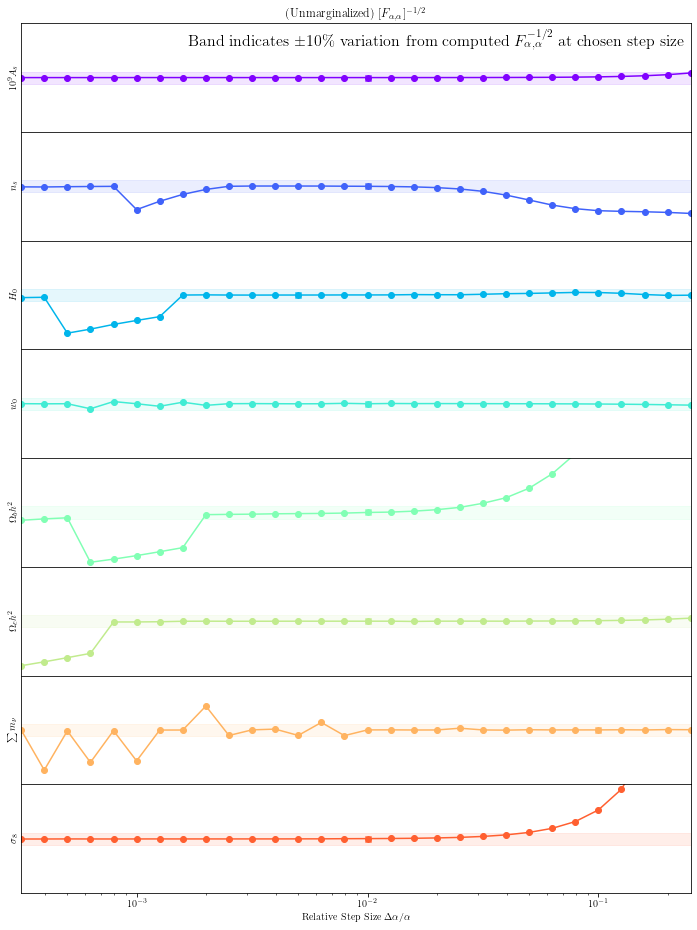

In [14]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Determine the number of subplots
n_parameters = len(fiducial_cosmology.keys())

# Create a figure and an array of subplots with 1 column
fig, axs = plt.subplots(n_parameters, 1, figsize=(12, 2 * n_parameters), sharex=True)

# Create a colormap
colormap = cm.rainbow

# Iterate over the parameters and the corresponding axes
for idx, (parameter_changed, ax) in enumerate(zip(fiducial_cosmology.keys(), axs)):
    Fii = []
    Fii_inv = []
    fiducial_value = None
    fiducial_step_size = fiducial_log10_rel_step_size[parameter_changed]

    for log10_rel_step_size in log10_rel_step_sizes:
        curr_theory_deriv = dμdθ_step_size[parameter_changed][log10_rel_step_size]
        Fii_0 = np.einsum('l,lm,m', curr_theory_deriv, cov_inv, curr_theory_deriv)
        Fii += [Fii_0]
        Fii_inv += [Fii_0**(-1)]
        if(np.abs(log10_rel_step_size - fiducial_step_size) < 1e-5):
            fiducial_value = Fii_0**(-1)

    # Get a color from the colormap based on the index
    color = colormap(float(idx) / n_parameters)

    X = 10**(log10_rel_step_sizes)
    ax.plot(X, ((Fii_inv)), color=color)
    ax.scatter(X, ((Fii_inv)), color=color)
    
    ax.scatter(10**fiducial_step_size, fiducial_value, color=color, marker='x')
    
    fill_x = np.array([10**(-10), 10**10])
    fill_y1 = [0.9 * (fiducial_value), 0.9 * (fiducial_value)]
    fill_y2 = [1.1 * (fiducial_value), 1.1 * (fiducial_value)]
    ax.fill_between(fill_x, fill_y1, fill_y2,  color=color, alpha=0.1)

    ax.set_xscale('log')
    l = labels[parameter_changed]
    ax.set_yticks([])
    
    ax.set_xlim([np.min(X), np.max(X)])

    ax.set_ylim([0.1 * (fiducial_value), 1.9 * (fiducial_value)])
    ax.set_ylabel(r'$%s$' % (l))
axs[0].set_title(r'(Unmarginalized) $[F_{\alpha, \alpha}]^{-1/2}$')
s = r'Band indicates ±10\% variation from computed $F^{-1/2}_{\alpha, \alpha}$ at chosen step size'
axs[0].text(.99, .95,
        s=s,
        transform=axs[0].transAxes,
        horizontalalignment='right',
        verticalalignment='top',
       fontsize=16)
axs[-1].set_xlabel(r'Relative Step Size $\Delta \alpha / \alpha$')
# Show the plot
plt.subplots_adjust(wspace=0, hspace=0)


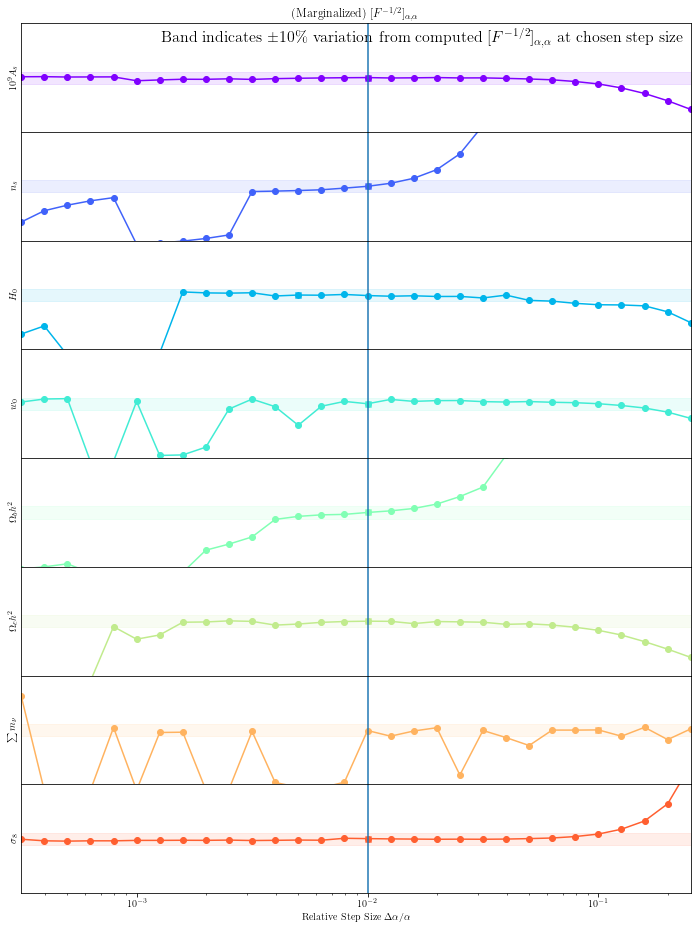

In [15]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.linalg import cho_solve, cho_factor

# Determine the number of subplots
n_parameters = len(fiducial_cosmology.keys())

# Create a figure and an array of subplots with 1 column
fig, axs = plt.subplots(n_parameters, 1, figsize=(12, 2 * n_parameters), sharex=True)

# Create a colormap
colormap = cm.rainbow

# Iterate over the parameters and the corresponding axes
for idx, (parameter_changed, ax) in enumerate(zip(fiducial_cosmology.keys(), axs)):
    Fii_inv = []
    fiducial_value = None
    fiducial_step_size = fiducial_log10_rel_step_size[parameter_changed]
    
    for log10_rel_step_size in log10_rel_step_sizes:
        fisher_matrix = np.zeros((n_parameters, n_parameters))

        for i, θi in enumerate(fiducial_cosmology.keys()):
            for j, θj in enumerate(fiducial_cosmology.keys()):
                dμl_θi = dμdθ_step_size[θi][log10_rel_step_sizes[fiducial_log10_rel_step_size_idx[θi]]]
                dμm_θj = dμdθ_step_size[θj][log10_rel_step_sizes[fiducial_log10_rel_step_size_idx[θj]]]
                if(θi == parameter_changed): 
                    dμl_θi = dμdθ_step_size[θi][log10_rel_step_size]
                if(θj == parameter_changed): 
                    dμm_θj = dμdθ_step_size[θj][log10_rel_step_size]
                fisher_matrix[i,j] = np.einsum('l,lm,m', dμl_θi, cov_inv, dμm_θj)

        # Compute the Cholesky decomposition
        cholesky_factor = cho_factor(fisher_matrix)

        # Solve for the inverse of the diagonal element
        e_i = np.zeros_like(fisher_matrix[idx])
        e_i[idx] = 1
        inv_diagonal_element = cho_solve(cholesky_factor, e_i)[idx]

        Fii_inv += [inv_diagonal_element]
        if np.abs(log10_rel_step_size - fiducial_step_size) < 1e-5:
            fiducial_value = inv_diagonal_element

            
            
            
            
    # Get a color from the colormap based on the index
    color = colormap(float(idx) / n_parameters)

    X = 10**(log10_rel_step_sizes)
    ax.plot(X, ((Fii_inv)), color=color)
    ax.scatter(X, ((Fii_inv)), color=color)

    ax.scatter(10**fiducial_step_size, fiducial_value, color=color, marker='x')
    
    fill_x = np.array([10**(-10), 10**10])
    fill_y1 = [0.9 * (fiducial_value), 0.9 * (fiducial_value)]
    fill_y2 = [1.1 * (fiducial_value), 1.1 * (fiducial_value)]
    ax.fill_between(fill_x, fill_y1, fill_y2,  color=color, alpha=0.1)

    ax.set_xscale('log')
    l = labels[parameter_changed]
    ax.set_yticks([])
    
    ax.set_xlim([np.min(X), np.max(X)])
    
    ax.set_ylim([0.1 * (fiducial_value), 1.9 * (fiducial_value)])
    ax.set_ylabel(r'$%s$' % (l))
    ax.axvline(10**-2)
axs[0].set_title(r'(Marginalized) $[F^{-1/2}]_{\alpha, \alpha}$')

s = r'Band indicates ±10\% variation from computed $[F^{-1/2}]_{\alpha, \alpha}$ at chosen step size'
axs[0].text(.99, .95,
        s=s,
        transform=axs[0].transAxes,
        horizontalalignment='right',
        verticalalignment='top',
       fontsize=16)

axs[-1].set_xlabel(r'Relative Step Size $\Delta \alpha / \alpha$')
# Show the plot
plt.subplots_adjust(wspace=0, hspace=0)


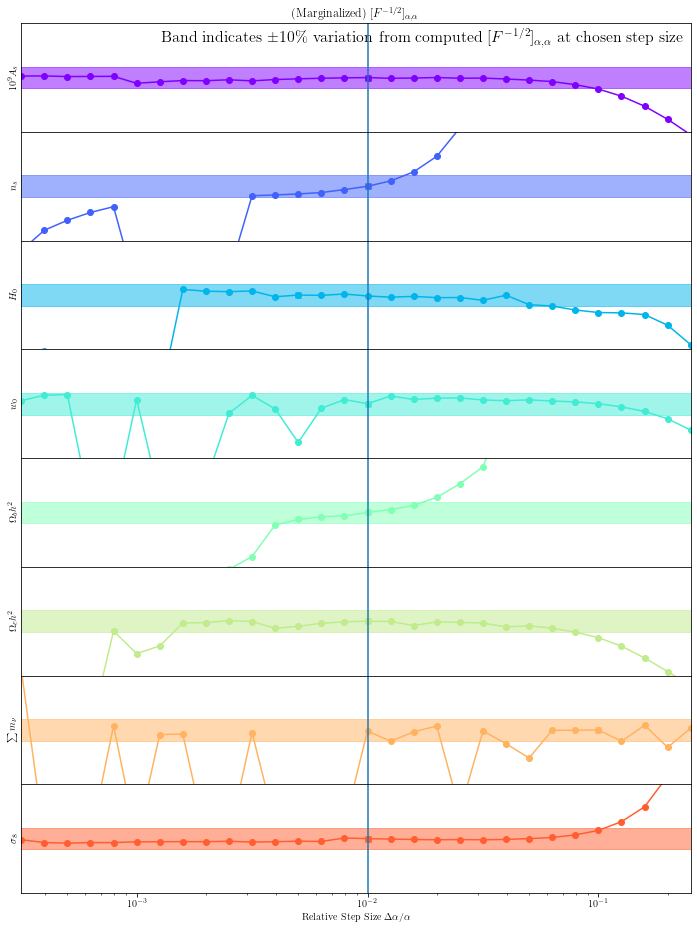

In [16]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.linalg import cho_solve, cho_factor

# Determine the number of subplots
n_parameters = len(fiducial_cosmology.keys())

# Create a figure and an array of subplots with 1 column
fig, axs = plt.subplots(n_parameters, 1, figsize=(12, 2 * n_parameters), sharex=True)

# Create a colormap
colormap = cm.rainbow

# Iterate over the parameters and the corresponding axes
for idx, (parameter_changed, ax) in enumerate(zip(fiducial_cosmology.keys(), axs)):
    Fii_inv = []
    fiducial_value = None
    fiducial_step_size = fiducial_log10_rel_step_size[parameter_changed]
    
    for log10_rel_step_size in log10_rel_step_sizes:
        fisher_matrix = np.zeros((n_parameters, n_parameters))

        for i, θi in enumerate(fiducial_cosmology.keys()):
            for j, θj in enumerate(fiducial_cosmology.keys()):
                dμl_θi = dμdθ_step_size[θi][log10_rel_step_sizes[fiducial_log10_rel_step_size_idx[θi]]]
                dμm_θj = dμdθ_step_size[θj][log10_rel_step_sizes[fiducial_log10_rel_step_size_idx[θj]]]
                if(θi == parameter_changed): 
                    dμl_θi = dμdθ_step_size[θi][log10_rel_step_size]
                if(θj == parameter_changed): 
                    dμm_θj = dμdθ_step_size[θj][log10_rel_step_size]
                fisher_matrix[i,j] = np.einsum('l,lm,m', dμl_θi, cov_inv, dμm_θj)

        # Compute the Cholesky decomposition
        cholesky_factor = cho_factor(fisher_matrix)

        # Solve for the inverse of the diagonal element
        e_i = np.zeros_like(fisher_matrix[idx])
        e_i[idx] = 1
        inv_diagonal_element = cho_solve(cholesky_factor, e_i)[idx]

        Fii_inv += [inv_diagonal_element]
        if np.abs(log10_rel_step_size - fiducial_step_size) < 1e-5:
            fiducial_value = inv_diagonal_element

            
            
            
            
    # Get a color from the colormap based on the index
    color = colormap(float(idx) / n_parameters)

    X = 10**(log10_rel_step_sizes)
    ax.plot(X, ((Fii_inv)), color=color)
    ax.scatter(X, ((Fii_inv)), color=color)

    ax.scatter(10**fiducial_step_size, fiducial_value, color=color, marker='x')
    
    fill_x = np.array([10**(-10), 10**10])
    fill_y1 = [0.9 * (fiducial_value), 0.9 * (fiducial_value)]
    fill_y2 = [1.1 * (fiducial_value), 1.1 * (fiducial_value)]
    ax.fill_between(fill_x, fill_y1, fill_y2,  color=color, alpha=0.5)

    ax.set_xscale('log')
    l = labels[parameter_changed]
    ax.set_yticks([])
    
    ax.set_xlim([np.min(X), np.max(X)])
    
    ax.set_ylim([0.5 * (fiducial_value), 1.5 * (fiducial_value)])
    ax.set_ylabel(r'$%s$' % (l))
    ax.axvline(10**-2)
axs[0].set_title(r'(Marginalized) $[F^{-1/2}]_{\alpha, \alpha}$')

s = r'Band indicates ±10\% variation from computed $[F^{-1/2}]_{\alpha, \alpha}$ at chosen step size'
axs[0].text(.99, .95,
        s=s,
        transform=axs[0].transAxes,
        horizontalalignment='right',
        verticalalignment='top',
       fontsize=16)

axs[-1].set_xlabel(r'Relative Step Size $\Delta \alpha / \alpha$')
# Show the plot
plt.subplots_adjust(wspace=0, hspace=0)


In [17]:
log10_rel_step_sizes = {}
old_spacing = np.arange(-3.5,-0.5,0.1)
log10_rel_step_sizes['10^9 As'] =  np.arange(-3.5,-0.5,0.1)
log10_rel_step_sizes['ns'] =  np.arange(-2.5,-1.8,0.02) #
log10_rel_step_sizes['H0'] =  np.arange(-3.5,-0.5,0.1)
log10_rel_step_sizes['w0'] =  np.arange(-2.1,-1.1,0.025) #

log10_rel_step_sizes['ombh2'] =  np.arange(-2.4,-1.4,0.025) #

log10_rel_step_sizes['omch2'] =  np.arange(-3,-0.5,0.1)
log10_rel_step_sizes['nu_mass_ev'] =  np.arange(-1.5,-0.5,0.025) #
log10_rel_step_sizes['sigma8'] =  np.arange(-3.5,-0.5,0.1)

for key in log10_rel_step_sizes:
    log10_rel_step_sizes[key] = np.union1d(log10_rel_step_sizes[key], old_spacing)
    
dμdθ_step_size = {}
for parameter_changed in tqdm(fiducial_cosmology.keys()):
    dμdθ_step_size[parameter_changed] = {}
    for log10_rel_step_size in log10_rel_step_sizes[parameter_changed]:
        cluster_abundance_pos = None
        cluster_abundance_neg = None
        fname_base = '/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/cluster_abundance_fisher_%s_%.4f'%(parameter_changed, log10_rel_step_size)
        with open(fname_base, 'rb') as file:
            cluster_abundance_pos = pickle.load(file)
        with open(fname_base+'_neg', 'rb') as file:
            cluster_abundance_neg = pickle.load(file)
        h = np.abs(fiducial_cosmology[parameter_changed]) * 10**log10_rel_step_size
        tmp_theory_deriv = (cluster_abundance_pos - cluster_abundance_neg) / (2 * h)
        flattened_theory_deriv = np.zeros((n_z * n_r))
        for i in range(n_z):
            for a in range(n_r):
                flattened_theory_deriv[i * n_r + a] = tmp_theory_deriv[i, a]
        dμdθ_step_size[parameter_changed][log10_rel_step_size] = flattened_theory_deriv


100%|██████████| 8/8 [00:00<00:00, 41.94it/s]


In [18]:
# Iterate over the parameters and the corresponding axes
fiducial_log10_rel_step_size = {
    '10^9 As': -2.,
    'ns': -2.4,
    'H0': -2.3,
    'w0': -1.7,
    'ombh2': -2.2,
    'omch2': -2,
    'nu_mass_ev': -1.075,
    'sigma8' : -2.
}

fiducial_log10_rel_step_size_idx = {key: np.argmin(np.abs(np.array(log10_rel_step_sizes[key]) - value)) 
                                    for key, value in fiducial_log10_rel_step_size.items()}

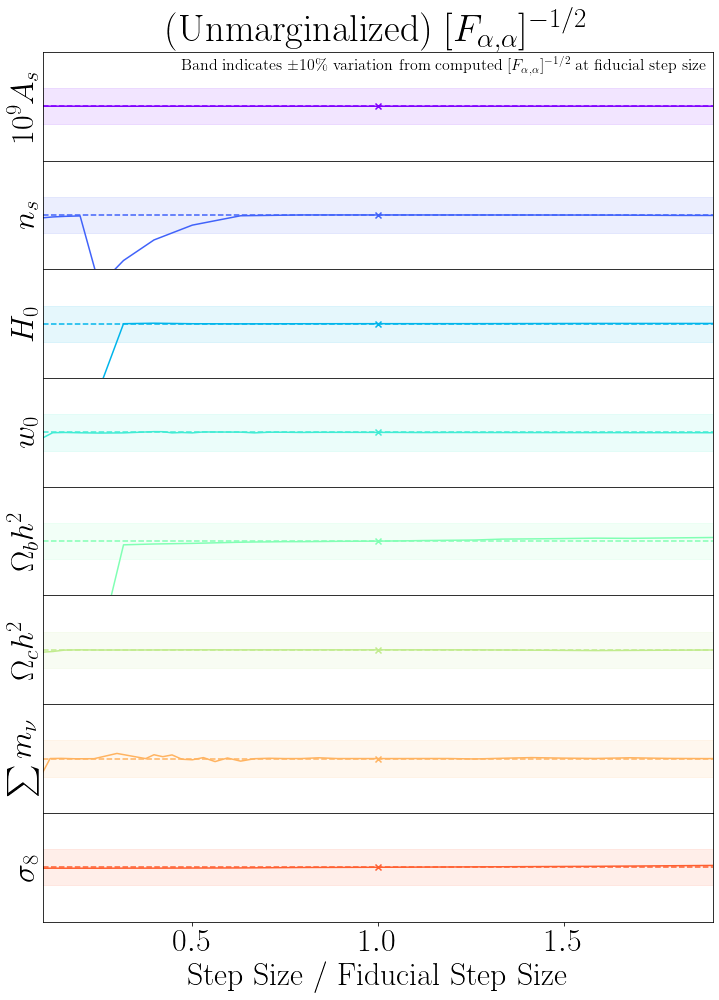

In [21]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.linalg import cho_solve, cho_factor
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 32
plt.rcParams['font.family'] = 'serif'

# Determine the number of subplots
n_parameters = len(fiducial_cosmology.keys())

# Create a figure and an array of subplots with 1 column
fig, axs = plt.subplots(n_parameters, 1, figsize=(12, 2 * n_parameters), sharex=True)

# Create a colormap
colormap = cm.rainbow

# Iterate over the parameters and the corresponding axes
for idx, (parameter_changed, ax) in enumerate(zip(fiducial_cosmology.keys(), axs)):
    Fii_inv = []
    fiducial_value = None
    fiducial_step_size = fiducial_log10_rel_step_size[parameter_changed]
    
    for log10_rel_step_size in log10_rel_step_sizes[parameter_changed]:
        fisher_matrix = np.zeros((n_parameters, n_parameters))

        for i, θi in enumerate(fiducial_cosmology.keys()):
            for j, θj in enumerate(fiducial_cosmology.keys()):
                dμl_θi = dμdθ_step_size[θi][log10_rel_step_sizes[θi][fiducial_log10_rel_step_size_idx[θi]]]
                dμm_θj = dμdθ_step_size[θj][log10_rel_step_sizes[θj][fiducial_log10_rel_step_size_idx[θj]]]
                if(θi == parameter_changed): 
                    dμl_θi = dμdθ_step_size[θi][log10_rel_step_size]
                if(θj == parameter_changed): 
                    dμm_θj = dμdθ_step_size[θj][log10_rel_step_size]
                fisher_matrix[i,j] = np.einsum('l,lm,m', dμl_θi, cov_inv, dμm_θj)

        inv_diagonal_element = fisher_matrix[idx, idx]**(-1)

        Fii_inv += [inv_diagonal_element]
        if np.abs(log10_rel_step_size - fiducial_step_size) < 1e-5:
            fiducial_value = inv_diagonal_element

            
            
            
            
    # Get a color from the colormap based on the index
    color = colormap(float(idx) / n_parameters)

    X = 10**(log10_rel_step_sizes[parameter_changed])
    X /= 10**fiducial_step_size
    
    ax.plot(X, ((Fii_inv)), color=color)
#     ax.scatter(X, ((Fii_inv)), color=color)

    ax.scatter(1, fiducial_value, color=color, marker='x')
    ax.axhline(fiducial_value, color=color, linestyle='--')
    
    fill_x = np.array([10**(-10), 10**10])
    fill_y1 = [0.9 * (fiducial_value), 0.9 * (fiducial_value)]
    fill_y2 = [1.1 * (fiducial_value), 1.1 * (fiducial_value)]
    ax.fill_between(fill_x, fill_y1, fill_y2,  color=color, alpha=0.1)

#     ax.set_xscale('log')
    l = labels[parameter_changed]
    ax.set_yticks([])
    
    ax.set_xlim([0.1,1.9])
    
    ax.set_ylim([0.7 * (fiducial_value), 1.3 * (fiducial_value)])
    ax.set_ylabel(r'$%s$' % (l))
#     ax.axvline(10**-2)
axs[0].set_title(r'(Unmarginalized) $[F_{\alpha, \alpha}]^{-1/2}$')
s = r'Band indicates ±10\% variation from computed $[F_{\alpha, \alpha}]^{-1/2}$ at fiducial step size'
axs[0].text(.99, .95,
        s=s,
        transform=axs[0].transAxes,
        horizontalalignment='right',
        verticalalignment='top',
       fontsize=16)

axs[-1].set_xlabel(r'Step Size / Fiducial Step Size')
plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig('unmarginalized_convergencee.pdf')

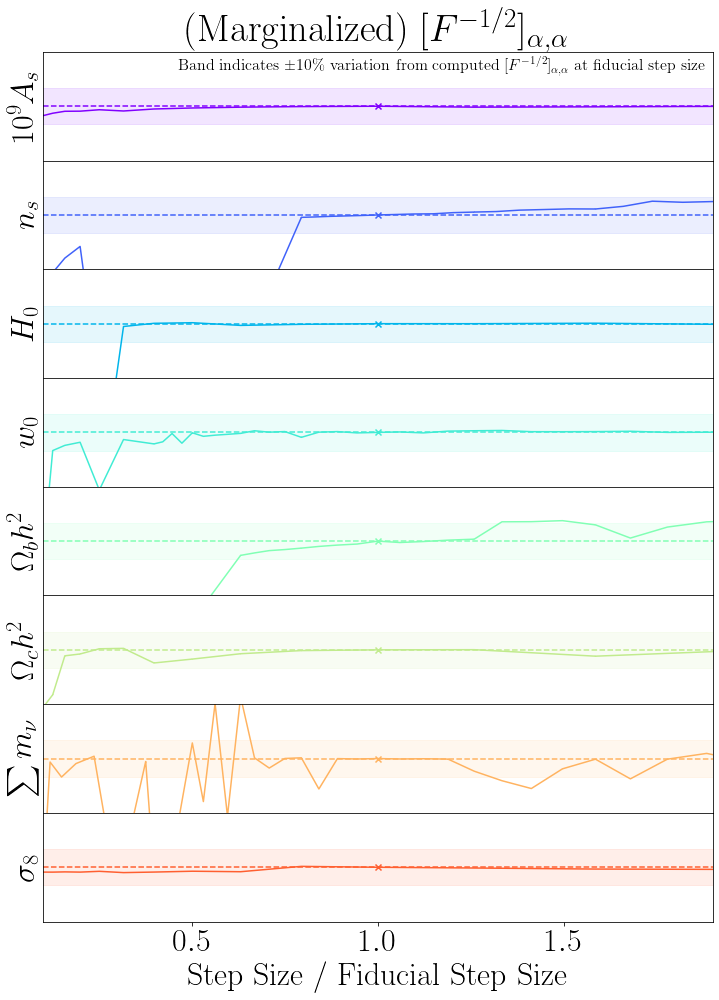

In [22]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.linalg import cho_solve, cho_factor
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 32
plt.rcParams['font.family'] = 'serif'

# Determine the number of subplots
n_parameters = len(fiducial_cosmology.keys())

# Create a figure and an array of subplots with 1 column
fig, axs = plt.subplots(n_parameters, 1, figsize=(12, 2 * n_parameters), sharex=True)

# Create a colormap
colormap = cm.rainbow

# Iterate over the parameters and the corresponding axes
for idx, (parameter_changed, ax) in enumerate(zip(fiducial_cosmology.keys(), axs)):
    Fii_inv = []
    fiducial_value = None
    fiducial_step_size = fiducial_log10_rel_step_size[parameter_changed]
    
    for log10_rel_step_size in log10_rel_step_sizes[parameter_changed]:
        fisher_matrix = np.zeros((n_parameters, n_parameters))

        for i, θi in enumerate(fiducial_cosmology.keys()):
            for j, θj in enumerate(fiducial_cosmology.keys()):
                dμl_θi = dμdθ_step_size[θi][log10_rel_step_sizes[θi][fiducial_log10_rel_step_size_idx[θi]]]
                dμm_θj = dμdθ_step_size[θj][log10_rel_step_sizes[θj][fiducial_log10_rel_step_size_idx[θj]]]
                if(θi == parameter_changed): 
                    dμl_θi = dμdθ_step_size[θi][log10_rel_step_size]
                if(θj == parameter_changed): 
                    dμm_θj = dμdθ_step_size[θj][log10_rel_step_size]
                fisher_matrix[i,j] = np.einsum('l,lm,m', dμl_θi, cov_inv, dμm_θj)

        # Compute the Cholesky decomposition
        cholesky_factor = cho_factor(fisher_matrix)

        # Solve for the inverse of the diagonal element
        e_i = np.zeros_like(fisher_matrix[idx])
        e_i[idx] = 1
        inv_diagonal_element = cho_solve(cholesky_factor, e_i)[idx]

        Fii_inv += [inv_diagonal_element]
        if np.abs(log10_rel_step_size - fiducial_step_size) < 1e-5:
            fiducial_value = inv_diagonal_element

            
            
            
            
    # Get a color from the colormap based on the index
    color = colormap(float(idx) / n_parameters)

    X = 10**(log10_rel_step_sizes[parameter_changed])
    X /= 10**fiducial_step_size
    
    ax.plot(X, ((Fii_inv)), color=color)
#     ax.scatter(X, ((Fii_inv)), color=color)

    ax.scatter(1, fiducial_value, color=color, marker='x')
    ax.axhline(fiducial_value, color=color, linestyle='--')
    
    fill_x = np.array([10**(-10), 10**10])
    fill_y1 = [0.9 * (fiducial_value), 0.9 * (fiducial_value)]
    fill_y2 = [1.1 * (fiducial_value), 1.1 * (fiducial_value)]
    ax.fill_between(fill_x, fill_y1, fill_y2,  color=color, alpha=0.1)

#     ax.set_xscale('log')
    l = labels[parameter_changed]
    ax.set_yticks([])
    
    ax.set_xlim([0.1,1.9])
    
    ax.set_ylim([0.7 * (fiducial_value), 1.3 * (fiducial_value)])
    ax.set_ylabel(r'$%s$' % (l))
#     ax.axvline(10**-2)
axs[0].set_title(r'(Marginalized) $[F^{-1/2}]_{\alpha, \alpha}$')

s = r'Band indicates ±10\% variation from computed $[F^{-1/2}]_{\alpha, \alpha}$ at fiducial step size'
axs[0].text(.99, .95,
        s=s,
        transform=axs[0].transAxes,
        horizontalalignment='right',
        verticalalignment='top',
       fontsize=16)

axs[-1].set_xlabel(r'Step Size / Fiducial Step Size')
plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig('marginalized_convergencee.pdf')

In [ ]:
Σ